Akash Kharita, 
</br> PhD Candidate, 
</br> University of Washington

## importing the dependencies

In [1]:
import numpy as np
import pandas as pd
from glob import glob 
from tqdm import tqdm
import seaborn as sns 

# for converting the text file containing the quarry locations into csv file
import csv

# for computing the geographical distance between two points 
import math


from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from datetime import datetime
import h5py
from sklearn.preprocessing import LabelEncoder
from scipy import stats, signal
from sklearn.preprocessing import StandardScaler
import obspy
from obspy.geodetics.base import gps2dist_azimuth, gps2dist_azimuth
from obspy.clients.fdsn import Client
import time
pd.set_option('display.max_columns', None)
from joblib import dump, load
from obspy.signal.filter import envelope
import tsfel


import sys
sys.path.append('../feature_extraction_scripts/physical_feature_extraction_scripts')
import seis_feature

sys.path.append('../src')

#from seis_feature import compute_physical_features
from tsfel import time_series_features_extractor, get_features_by_domain
from datetime import timedelta
import os


from utils import apply_cosine_taper
from utils import butterworth_filter
from utils import plot_confusion_matrix
from utils import plot_classification_report
from utils import calculate_distance


import pickle
from zenodo_get import zenodo_get

#import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Loading and combining Features

### Downloading tsfel features

In [2]:
## Downloading the physical features 
## This is doi for physical features (for both 50s and 150s) - 10.5281/zenodo.10689585
## This is doi for tsfel features of 50s window length - 10.5281/zenodo.10689673
## This is doi for tsfel features of 150s window length - 10.5281/zenodo.10689824

doi = '10.5281/zenodo.10689824'  #Downloading tsfel features for 150s length
# Download files from the Zenodo record
files = zenodo_get([doi])

Title: Tsfel Features for my study on Automatic Seismic Event Classification System in Pacific Northwest (150s)
Keywords: 
Publication date: 2024-02-21
DOI: 10.5281/zenodo.10689824
Total size: 1483.0 MB

Link: https://zenodo.org/record/10689824/files/tsfel_features_comcat_z_earthquake_50_100_part3.csv   size: 411.4 MB
tsfel_features_comcat_z_earthquake_50_100_part3.csv is already downloaded correctly.

Link: https://zenodo.org/record/10689824/files/tsfel_features_comcat_z_earthquake_50_100_part2.csv   size: 295.7 MB
tsfel_features_comcat_z_earthquake_50_100_part2.csv is already downloaded correctly.

Link: https://zenodo.org/record/10689824/files/tsfel_features_comcat_z_explosion_50_100.csv   size: 96.9 MB

Checksum is correct. (03b0d7d98ca50fa6d108ed88297d4c87)

Link: https://zenodo.org/record/10689824/files/tsfel_features_noise_50_100.csv   size: 314.8 MB

Checksum is correct. (74a2bb0aa317db40a35c77aa1a7de922)

Link: https://zenodo.org/record/10689824/files/tsfel_features_exotic_50_

### Loading tsfel features

In [3]:
# These waveforms are filtered between 1-10 Hz
# extracting features of surface events, thunder and sonic booms
features_exotic_tsfel = pd.read_csv('tsfel_features_exotic_50_100.csv')




# features of noise
features_noise_tsfel = pd.read_csv('tsfel_features_noise_50_100.csv')





# features of explosion
features_explosion_tsfel = pd.read_csv('tsfel_features_comcat_z_explosion_50_100.csv')



# features of earthquake (had to extract it in three parts because of memory constraints)
features_eq1 = pd.read_csv('tsfel_features_comcat_z_earthquake_50_100_part1.csv')
features_eq2 = pd.read_csv('tsfel_features_comcat_z_earthquake_50_100_part2.csv')
features_eq3 = pd.read_csv('tsfel_features_comcat_z_earthquake_50_100_part3.csv')



# features of earthquakes
features_earthquake_tsfel = pd.concat([features_eq1, features_eq2, features_eq3])

## Removing highly correlated tsfel features

In [4]:
# Highly correlated features are removed, default correlation threshold is 0.95
# pearson correlation method is used. 
corr_features = tsfel.correlated_features(features_noise_tsfel.iloc[:, 1:390])


features_exotic_tsfel.drop(corr_features, axis=1, inplace=True)
features_noise_tsfel.drop(corr_features, axis=1, inplace=True)
features_explosion_tsfel.drop(corr_features, axis=1, inplace=True)
features_earthquake_tsfel.drop(corr_features, axis=1, inplace=True)

## There are a total of 390 columns that contain tsfel features

## Note that each dataframe contains three additional columns - 

-  the initial unnamed 0 column, not sure why it is there. 
- The 'serial_no' column this was added to identify the similar event to alllow merging of tsfel and physical features. Each event is associated with unique serial number. 
- The serial no. is equal to the iteration number when looping through the catalog of specific source type. 
- Third column added was the 'source'

### Downloading physical features

In [5]:
## Downloading the physical features 
## This is doi for physical features (for both 50s and 150s) - 10.5281/zenodo.10689585
## This is doi for tsfel features of 50s window length - 10.5281/zenodo.10689673
## This is doi for tsfel features of 150s window length - 10.5281/zenodo.10689824

doi = '10.5281/zenodo.11193585'  #Downloading physical
# Download files from the Zenodo record
files = zenodo_get([doi])

Title: Physical Features for my study on Automatic Seismic Event Classification System in Pacific Northwest (Origin time - 50, +100)
Keywords: 
Publication date: 2024-05-14
DOI: 10.5281/zenodo.11193585
Total size: 179.7 MB

Link: https://zenodo.org/record/11193585/files/new_physical_features_exotic_z_50_100.csv   size: 6.9 MB

Checksum is correct. (ba4427cce08202f12ed96eb8e0ada953)

Link: https://zenodo.org/record/11193585/files/new_physical_features_comcat_z_explosion_50_100.csv   size: 11.7 MB

Checksum is correct. (b98eb04772713626a9102d11f50cdddb)

Link: https://zenodo.org/record/11193585/files/new_physical_features_noise_z_50_100.csv   size: 38.1 MB

Checksum is correct. (36a8f8c93828712699c56682c8403f56)

Link: https://zenodo.org/record/11193585/files/new_physical_features_earthquake_z_part3_50_100.csv   size: 35.9 MB

Checksum is correct. (495e768402c1128600997c7cf06b9c32)

Link: https://zenodo.org/record/11193585/files/new_physical_features_earthquake_z_part2_50_100.csv   size:

### Loading physical features

In [6]:
# extracting features of surface events, thunder and sonic booms
features_exotic_physical = pd.read_csv('new_physical_features_exotic_z_50_100.csv')

features_surface_physical = features_exotic_physical[features_exotic_physical['source'] == 'surface']
features_sonic_physical = features_exotic_physical[features_exotic_physical['source'] == 'sonic']
features_thunder_physical = features_exotic_physical[features_exotic_physical['source'] == 'thunder']



# features of noise
features_noise_physical = pd.read_csv('new_physical_features_noise_z_50_100.csv')


# features of explosion
features_explosion_physical = pd.read_csv('new_physical_features_comcat_z_explosion_50_100.csv')

# features of earthquakes
features_eq1 = pd.read_csv('new_physical_features_earthquake_z_part1_50_100.csv')
features_eq2 = pd.read_csv('new_physical_features_earthquake_z_part2_50_100.csv')
features_eq3 = pd.read_csv('new_physical_features_earthquake_z_part3_50_100.csv')
features_eq4 = pd.read_csv('new_physical_features_earthquake_z_part4_50_100.csv')

features_earthquake_physical = pd.concat([features_eq1, features_eq2, features_eq3, features_eq4])

## Removing highly correlated physical features

In [7]:
# Highly correlated features are removed, default correlation threshold is 0.95
# pearson correlation method is used. 


corr_features = tsfel.correlated_features(features_noise_physical.iloc[:, 1:63])


features_exotic_physical.drop(corr_features, axis=1, inplace=True)
features_noise_physical.drop(corr_features, axis=1, inplace=True)
features_explosion_physical.drop(corr_features, axis=1, inplace=True)
features_earthquake_physical.drop(corr_features, axis=1, inplace=True)

## Deleting the directory

In [8]:
# Get the current working directory
directory = os.getcwd()

# List the files in the directory
files = os.listdir(directory)

# Iterate over the files and delete CSV files
for file in files:
    if file.endswith(".csv"):
        file_path = os.path.join(directory, file)
        os.remove(file_path)

## There are total of 62 engineered/physical features

## Merging tsfel + physical features

In [9]:
features_noise = pd.merge(features_noise_physical, features_noise_tsfel, on = 'serial_no')
features_earthquake = pd.merge(features_earthquake_physical, features_earthquake_tsfel, on = 'serial_no')
features_explosion = pd.merge(features_explosion_physical, features_explosion_tsfel, on = 'serial_no')


features_surface_tsfel = features_exotic_tsfel[features_exotic_tsfel['source'] == 'surface']
features_sonic_tsfel = features_exotic_tsfel[features_exotic_tsfel['source'] == 'sonic']
features_thunder_tsfel = features_exotic_tsfel[features_exotic_tsfel['source'] == 'thunder']

features_surface_physical = features_exotic_physical[features_exotic_physical['source'] == 'surface']
features_sonic_physical = features_exotic_physical[features_exotic_physical['source'] == 'sonic']
features_thunder_physical = features_exotic_physical[features_exotic_physical['source'] == 'thunder']


features_surface = pd.merge(features_surface_physical, features_surface_tsfel, on = 'serial_no')
features_sonic = pd.merge(features_sonic_physical, features_sonic_tsfel, on = 'serial_no')
features_thunder = pd.merge(features_thunder_physical, features_thunder_tsfel, on = 'serial_no')



features_all = pd.concat([features_surface, features_sonic, features_thunder, features_noise, features_explosion, features_earthquake])

In [10]:
features_all

,Unnamed: 0_x,Window_Length,RappMaxMean,RappMaxMedian,AsDec,KurtoSig,KurtoEnv,SkewSig,SkewEnv,CorPeakNumber,Energy1/3Cor,Energy2/3Cor,int_ratio,MeanFFT,MaxFFT,FMaxFFT,MedianFFT,VarFFT,FCentroid,Fquart3,NPeakFFT,MeanPeaksFFT,E2FFT,E3FFT,E4FFT,Gamma,KurtoMaxDFT,KurtoMedianDFT,MaxOverMeanDFT,MaxOverMedianDFT,NbrPeaksMaxDFT,NbrPeaksMeanDFT,NbrPeaksMedianDFT,45/46,45/47,NbrPeaksCentralFreq,NbrPeaksMaxFreq,50/51,DistMaxMeanFreqDTF,DistQ2Q1DFT,DistQ3Q2DFT,DistQ3Q1DFT,Peak_Envelope_Amplitude,Average_Envelope_Amplitude,Envelope_Rise_Time,E_0.1_1,Kurto_0.1_1,E_1_3,Kurto_1_3,E_3_10,E_10_20,Kurto_10_20,E_20_50,Kurto_20_50,serial_no,source_x,Unnamed: 0_y,0_FFT mean coefficient_0,0_FFT mean coefficient_1,0_FFT mean coefficient_2,0_FFT mean coefficient_3,0_FFT mean coefficient_4,0_FFT mean coefficient_5,0_FFT mean coefficient_6,0_FFT mean coefficient_7,0_FFT mean coefficient_8,0_FFT mean coefficient_9,0_FFT mean coefficient_10,0_FFT mean coefficient_11,0_FFT mean coefficient_12,0_FFT mean coefficient_13,0_FFT mean coefficient_14,0_FFT mean coefficient_15,0_FFT mean coefficient_16,0_FFT mean coefficient_17,0_FFT mean coefficient_18,0_FFT mean coefficient_19,0_FFT mean coefficient_20,0_FFT mean coefficient_21,0_FFT mean coefficient_22,0_FFT mean coefficient_23,0_FFT mean coefficient_24,0_FFT mean coefficient_25,0_FFT mean coefficient_26,0_FFT mean coefficient_27,0_FFT mean coefficient_28,0_FFT mean coefficient_29,0_FFT mean coefficient_30,0_FFT mean coefficient_31,0_FFT mean coefficient_32,0_FFT mean coefficient_33,0_FFT mean coefficient_34,0_FFT mean coefficient_35,0_FFT mean coefficient_36,0_FFT mean coefficient_37,0_FFT mean coefficient_38,0_FFT mean coefficient_39,0_FFT mean coefficient_40,0_FFT mean coefficient_41,0_FFT mean coefficient_42,0_FFT mean coefficient_43,0_FFT mean coefficient_44,0_FFT mean coefficient_45,0_FFT mean coefficient_46,0_FFT mean coefficient_47,0_FFT mean coefficient_48,0_FFT mean coefficient_49,0_FFT mean coefficient_50,0_FFT mean coefficient_51,0_FFT mean coefficient_52,0_FFT mean coefficient_53,0_FFT mean coefficient_54,0_FFT mean coefficient_55,0_FFT mean coefficient_56,0_FFT mean coefficient_57,0_FFT mean coefficient_58,0_FFT mean coefficient_59,0_FFT mean coefficient_60,0_FFT mean coefficient_61,0_FFT mean coefficient_62,0_FFT mean coefficient_63,0_FFT mean coefficient_64,0_FFT mean coefficient_65,0_FFT mean coefficient_66,0_FFT mean coefficient_67,0_FFT mean coefficient_68,0_FFT mean coefficient_69,0_FFT mean coefficient_70,0_FFT mean coefficient_71,0_FFT mean coefficient_72,0_FFT mean coefficient_73,0_FFT mean coefficient_74,0_FFT mean coefficient_75,0_FFT mean coefficient_76,0_FFT mean coefficient_77,0_FFT mean coefficient_78,0_FFT mean coefficient_79,0_FFT mean coefficient_80,0_FFT mean coefficient_81,0_FFT mean coefficient_82,0_FFT mean coefficient_83,0_FFT mean coefficient_84,0_FFT mean coefficient_85,0_FFT mean coefficient_86,0_FFT mean coefficient_87,0_FFT mean coefficient_88,0_FFT mean coefficient_89,0_FFT mean coefficient_90,0_FFT mean coefficient_91,0_FFT mean coefficient_92,0_FFT mean coefficient_93,0_FFT mean coefficient_94,0_FFT mean coefficient_95,0_FFT mean coefficient_96,0_FFT mean coefficient_98,0_FFT mean coefficient_99,0_FFT mean coefficient_100,0_FFT mean coefficient_101,0_FFT mean coefficient_102,0_FFT mean coefficient_103,0_FFT mean coefficient_104,0_FFT mean coefficient_105,0_FFT mean coefficient_106,0_FFT mean coefficient_107,0_FFT mean coefficient_113,0_FFT mean coefficient_114,0_FFT mean coefficient_116,0_FFT mean coefficient_117,0_FFT mean coefficient_118,0_FFT mean coefficient_125,0_FFT mean coefficient_126,0_FFT mean coefficient_127,0_FFT mean coefficient_128,0_FFT mean coefficient_129,0_FFT mean coefficient_130,0_FFT mean coefficient_131,0_FFT mean coefficient_132,0_FFT mean coefficient_133,0_FFT mean coefficient_134,0_FFT mean coefficient_135,0_FFT mean coefficient_136,0_FFT mean coefficient_137,0_FFT mean coefficient_138,0_FFT mean coefficient_139,0_FFT mean coefficient_140,0_F

##  So there should be 454 columns (390 tsfel + 62 physical +1 source + 1serial no.) so we need to drop all other columns 

In [11]:
features_all = features_all.drop(['Unnamed: 0_x','Unnamed: 0_y', 'source_x'], axis = 1)
features_all.rename(columns={'source_y': 'source'}, inplace=True)
print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')

So we have 240678 events and each event have 322 features


## Preprocessing the input features

In [12]:
# dropping the columns that contain NaNs
features_all = features_all.dropna(axis = 1)

# dropping the rows that contains NaNs
features_all = features_all.dropna()


## dropping all the rows containing infinity values
features_all = features_all.replace([np.inf, -np.inf], np.nan).dropna()


## dropping sonic boom and thunder events
features_all = features_all[features_all['source'] != 'sonic']
features_all = features_all[features_all['source'] != 'thunder']

print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')


So we have 240326 events and each event have 321 features


## Dropping the columns that contain same values for all the events, as these features do not really contribute in classification

In [13]:
# Check unique values in each column
unique_counts = features_all.nunique()

# Identify columns with only one unique value (same value for all rows)
single_value_columns = unique_counts[unique_counts == 1].index


# Drop columns with the same value for all rows
features_all = features_all.drop(columns=single_value_columns)

print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')


So we have 240326 events and each event have 305 features


## Data Cleaning

### Removing the outliers

In [14]:
df = features_all.drop(['serial_no', 'source'], axis = 1)
# Calculate Z-scores for each feature
z_scores = np.abs(stats.zscore(df))


# Define a threshold for Z-score beyond which data points are considered outliers
threshold = 4

# Filter out rows with any Z-score greater than the threshold
# Temporarily removing this 
outliers_removed_df =   features_all[(z_scores < threshold).all(axis=1)]

print(len(features_all))
print(len(outliers_removed_df))


240326
169202


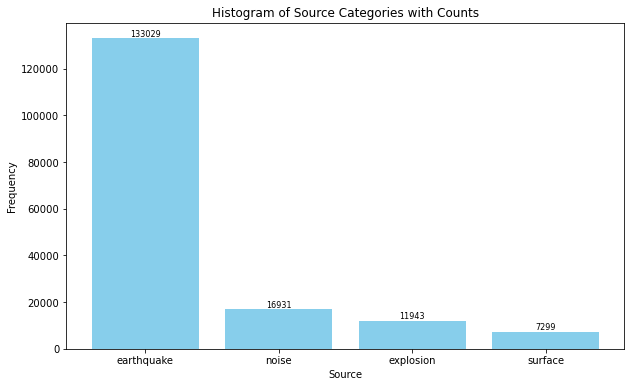

In [15]:
# Assuming 'source' is a categorical column in your DataFrame
categories, counts = outliers_removed_df['source'].value_counts().index, outliers_removed_df['source'].value_counts().values

plt.figure(figsize=(10, 6))

# Plot the histogram
plt.bar(categories, counts, color='skyblue')

# Add text annotations on top of each bar
for i, count in enumerate(counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=8, color='black')

plt.xlabel('Source')
plt.ylabel('Frequency')
plt.title('Histogram of Source Categories with Counts')

plt.show()


In [16]:
print(f'So we now have {outliers_removed_df.shape[0]} events and each event have {outliers_removed_df.shape[1]} features')

So we now have 169202 events and each event have 305 features


### Standardizing the features

In [17]:
## defining the global variables X and y
X = outliers_removed_df.drop(['serial_no','source'], axis = 1)
y = outliers_removed_df['source']


# Initialize the StandardScaler
scaler = StandardScaler()



# Apply standard scaling to the DataFrame
scaled_features = scaler.fit_transform(X)


# Access the mean and standard deviation for each feature
means = scaler.mean_
std_devs = scaler.scale_

# Create a DataFrame to display the means and standard deviations
scaler_params = pd.DataFrame({'Feature': X.columns, 'Mean': means, 'Std Dev': std_devs})
print(scaler_params)


# Create a new DataFrame with scaled features
X_scaled = pd.DataFrame(scaled_features, columns=X.columns)


## We are not standardizing at this stage. We will rather wait when the outlier are removed, then we will
## standardize and save the standard scaler parameters. 
#X_scaled = X

X_scaled['serial_no'] = outliers_removed_df['serial_no'].values
X_scaled['source'] = outliers_removed_df['source'].values

                       Feature         Mean     Std Dev
0                  RappMaxMean    11.095431    7.541387
1                RappMaxMedian    30.638134   86.954568
2                        AsDec     0.872060    0.701873
3                     KurtoSig    54.856133   62.609953
4                     KurtoEnv    25.001943   21.013240
..                         ...          ...         ...
298              0_Median diff     0.000013    0.000140
299  0_Negative turning points  1104.134224  177.998639
300      0_Neighbourhood peaks   577.021430   83.652912
301    0_Peak to peak distance     1.848017    0.106414
302       0_Zero crossing rate  1425.625814  391.017375

[303 rows x 3 columns]


# IMP - Saving the Standard Scaler Params

#### X_scaled is a standardized dataframe

In [18]:
scaler_params.to_csv('../results/scaler_params.csv')

## Merging the metadata information with the features dataframe

In [19]:
# extracting the stored data
comcat_file_name = h5py.File("/data/whd01/yiyu_data/PNWML/comcat_waveforms.hdf5",'r')
exotic_file_name = h5py.File("/data/whd01/yiyu_data/PNWML/exotic_waveforms.hdf5",'r')
noise_file_name = h5py.File("/data/whd01/yiyu_data/PNWML/noise_waveforms.hdf5",'r')


# extracting the catalog
comcat_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/comcat_metadata.csv")
exotic_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")
noise_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/noise_metadata.csv")



# extracting the metadata corresponding to individual events
cat_exp = comcat_file_csv[comcat_file_csv['source_type'] == 'explosion']
cat_eq = comcat_file_csv[comcat_file_csv['source_type'] == 'earthquake']
cat_no = noise_file_csv
cat_su = exotic_file_csv[exotic_file_csv['source_type'] == 'surface event']



# extracting the index 
ind_exp = X_scaled[X_scaled['source'] == 'explosion']['serial_no'].values
ind_eq = X_scaled[X_scaled['source'] == 'earthquake']['serial_no'].values
ind_no = X_scaled[X_scaled['source'] == 'noise']['serial_no'].values
ind_su = X_scaled[X_scaled['source'] == 'surface']['serial_no'].values


df_exp = X_scaled[X_scaled['source'] == 'explosion']
exp_df = cat_exp.iloc[ind_exp]
exp_df['serial_no'] = ind_exp


df_eq = X_scaled[X_scaled['source'] == 'earthquake']
eq_df = cat_eq.iloc[ind_eq]
eq_df['serial_no'] = ind_eq



df_no = X_scaled[X_scaled['source'] == 'noise']
no_df = cat_no.iloc[ind_no]
no_df['serial_no'] = ind_no



df_su = X_scaled[X_scaled['source'] == 'surface']
su_df = cat_su.iloc[ind_su]
su_df['serial_no'] = ind_su





new_exp = pd.merge(df_exp,exp_df, on = 'serial_no')
new_eq = pd.merge(df_eq,eq_df, on = 'serial_no')
new_su = pd.merge(df_su,su_df, on = 'serial_no')
new_no = pd.merge(df_no,no_df, on = 'serial_no')
new_no['event_id'] = np.array(['noise'+str(i) for i in np.arange(len(new_no))])



X_final = pd.concat([new_exp, new_eq, new_su, new_no])
y = ['explosion']*len(new_exp)+['earthquake']*len(new_eq)+['surface']*len(new_su)+['noise']*len(new_no)



/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


### Adding Hour of the Day, Days of Week and Month of Year as additional features as they have shown to significantly increase the performance of the machine learning model

In [20]:
# new_exp contains the features and the corresponding metadata information. 
datetimes = X_final['trace_start_time'].values

hour_of_day = []
days_of_week = []
month_of_year = []
for dt_str in tqdm(datetimes):
        
    # Parse the datetime string
        dt = datetime.strptime(dt_str, '%Y-%m-%dT%H:%M:%S.%fZ')
        hod = dt.hour - 8.  # converting to local time. 
        moy = dt.month
        
        
        days_of_week.append(dt.weekday())
        hour_of_day.append(hod)
        month_of_year.append(moy)
        
X_final['hour_of_day'] = hour_of_day
X_final['day_of_week'] = days_of_week
X_final['month_of_year'] = month_of_year


100%|██████████| 169202/169202 [00:01<00:00, 144631.41it/s]


In [21]:
temp_X = X_final.iloc[:,0:303]
#temp_X = temp_X.assign(hod=X_final['hour_of_day'].values, dow=X_final['day_of_week'].values, moy=X_final['month_of_year'].values)



# Initialize the StandardScaler
scaler = StandardScaler()

# Apply standard scaling to the DataFrame
scaled_features = scaler.fit_transform(temp_X)

# Create a new DataFrame with scaled features
temp_X = pd.DataFrame(scaled_features, columns= temp_X.columns)



## So X_final that contains the features and corresponding metadata information for all the events

### hyperparameter tuning of the model based on 3000 samples per class and splitting into 80-20%.

In [22]:
# Apply random undersampling using imbalanced-learn library
rus = RandomUnderSampler(sampling_strategy={'earthquake':3000, 'explosion':3000, 'surface':3000, 'noise':3000})
X_resampled, y_resampled = rus.fit_resample(temp_X, y)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the LabelEncoder on the text labels and transform them to numeric labels
y_num = label_encoder.fit_transform(y_resampled)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_num, test_size=0.2, stratify = y_num)



# Define the hyperparameter grid for randomized search
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Initialize the RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_dist, n_iter=50, scoring='f1_macro', cv=10, verbose=0, random_state=42, n_jobs=-1
)

# Perform randomized grid search cross-validation
random_search.fit(X_train, y_train)

# Print the best parameters and their corresponding accuracy score
print("Best Parameters:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = np.sum(y_pred == y_test) / len(y_test)
print("Test Accuracy:", accuracy)




Best Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': False}
Best Accuracy: 0.930917292447
Test Accuracy: 0.93125


## Saving the best model into disk so next time we can just load it

In [23]:
dump(best_model, '../results/best_rf_model_all_features_50_100.joblib')

['../results/best_rf_model_all_features_50_100.joblib']

## Loading the saved model from the disk

In [24]:
bf = load('../results/best_rf_model_all_features_50_100.joblib')

In [25]:
bf

RandomForestClassifier(bootstrap=False, n_estimators=500, random_state=42)

## Plotting the confusion matrix and classification report for the best model found above.


A **confusion matrix** is a table used to evaluate the performance of a classification algorithm. It provides a comprehensive summary of the prediction results by comparing the predicted and actual classes. The matrix shows the number of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN), which are essential for understanding how well the model performs in terms of accuracy, precision, recall, and other metrics.

A **classification report** is a detailed summary of the performance of a classification algorithm, which includes key metrics such as precision, recall, F1-score, and support for each class. This report is especially useful for evaluating the effectiveness of a model on a classification problem, providing a more granular view of performance across different classes.


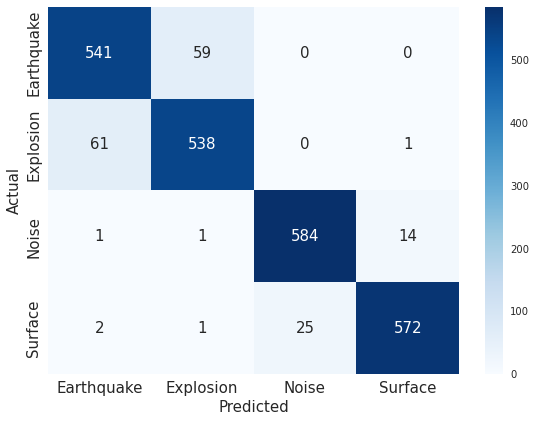

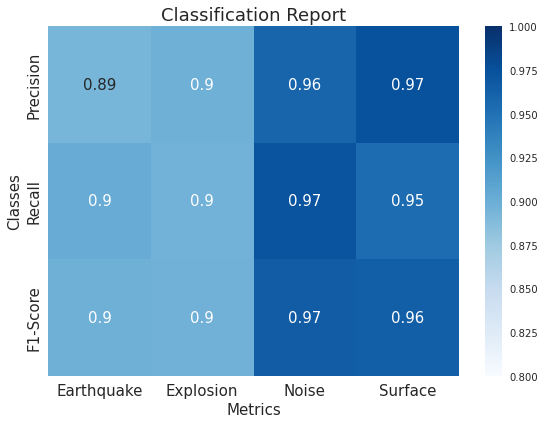

In [28]:
## plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)


# Calculate the classification report
report = classification_report(y_test, y_pred, output_dict=True)
plot_classification_report(report)

## Computing the feature importance

Feature importance refers to techniques that assign scores to input features based on their relevance in predicting the target variable. Understanding feature importance helps in interpreting models, reducing dimensionality, and improving model performance by focusing on the most impactful features.

In Random Forests, feature importance is calculated based on how much each feature contributes to reducing the impurity (e.g., Gini impurity or entropy) of the nodes in the decision trees. During training, each tree in the forest is built using a subset of the data and a random selection of features. The importance of a feature is determined by measuring the decrease in impurity that it causes when used for splitting nodes in the tree. Features that lead to large impurity decreases across all trees in the forest are considered more important, as they play a significant role in the model's ability to make accurate predictions. These importance scores are then averaged across all trees to determine the final importance of each feature, which can be used to understand the relative contribution of different features to the model's performance.

## Feature Importance computation with built-in method over 10 iterations

In [29]:
num_iter = 10
f_imp = []

for i in tqdm(range(num_iter)):

    # Apply random undersampling using imbalanced-learn library
    rus = RandomUnderSampler(sampling_strategy={'earthquake':3000, 'explosion':3000, 'surface':3000, 'noise':3000})
    X_resampled, y_resampled = rus.fit_resample(temp_X, y)

    # Initialize the LabelEncoder
    label_encoder = LabelEncoder()

    # Fit the LabelEncoder on the text labels and transform them to numeric labels
    y_num = label_encoder.fit_transform(y_resampled)


    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_num, test_size=0.2, stratify = y_num)

    # Perform randomized grid search cross-validation
    best_model.fit(X_train, y_train)


    f_imp.append(best_model.feature_importances_)

100%|██████████| 10/10 [15:57<00:00, 95.73s/it]


In [30]:
final_imp = np.mean(f_imp, axis = 0)
features = X_train.columns.values
feature_colors = ['darkred']*49+['darkblue']*(len(features)-49)  # red for physical and blue for tsfel features. 

## Removing the 0 from the starting of each feature name
## the second argument in split specifies the maxsplit, the amount of times the split will be performed. 

feature_names = np.hstack([features[0:49],[features[49:][i].split('_', 1)[1] for i in range(len(features[49:]))]])

## Plotting the feature importance

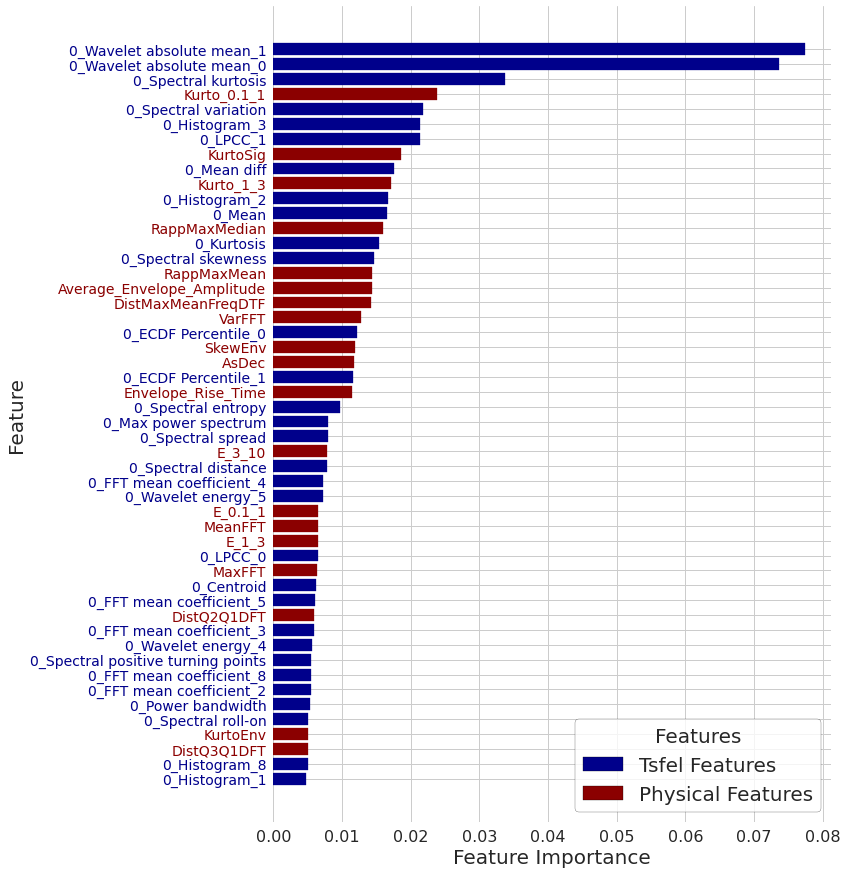

In [31]:
# Set rc parameters for font size
plt.rcParams['xtick.labelsize'] = 16  # Font size for xtick labels
plt.rcParams['ytick.labelsize'] = 20  # Font size for ytick labels
# Sample feature importances and feature labels
feature_importances = final_imp
feature_labels = features

# Sort feature importances and feature labels together
sorted_indices = sorted(range(len(feature_importances)), key=lambda k: feature_importances[k], reverse=True)
sorted_feature_importances = [feature_importances[i] for i in sorted_indices]
sorted_feature_labels = [feature_labels[i] for i in sorted_indices]
colors = [feature_colors[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(10, 15))
bars = plt.barh(sorted_feature_labels[0:50], sorted_feature_importances[0:50])

# Color bars to match yticklabels
for bar, color in zip(bars, colors):
    bar.set_color(color)

# Color yticklabels and increase font size
for label, color in zip(plt.gca().get_yticklabels(), colors):
    label.set_color(color)
    #label.set_fontsize(20)  # Set desired font size here

# Create legend handles and labels
legend_handles = [plt.Rectangle((0,0),1,1, color='darkblue', ec='black'), plt.Rectangle((0,0),1,1, color='darkred', ec='black')]
legend_labels = ['Tsfel Features', 'Physical Features']

plt.legend(legend_handles, legend_labels, title='Features', title_fontsize=20, frameon=True, fontsize = 20, facecolor='white', edgecolor='black')

plt.xlabel('Feature Importance', fontsize=20)
plt.ylabel('Feature', fontsize=20)
#plt.title('Top 50 Feature Importances', fontsize=20)
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top

# Set y-axis tick label size
plt.yticks(fontsize=14)

plt.show()


## Performance variation with the cumulative number of the most important features

In [32]:
## based on the X_train and X_test computed previously. They should contain 2400 and 600 events per class respectively. 
results_dict = []
selected_features = []

for i in tqdm(range(1, len(sorted_feature_labels), 10)):
    selected_features = sorted_feature_labels[0:i]
    X_temp_train = X_train[selected_features].copy()
    X_temp_test = X_test[selected_features].copy()
    bf.fit(X_temp_train, y_train)
    
    y_pred = bf.predict(X_temp_test)
    results_dict.append(classification_report(y_test, y_pred, output_dict=True))


100%|██████████| 31/31 [32:10<00:00, 62.26s/it]


## Saving the above file

since it took considerable time to compute, its a better idea to save it

In [32]:
## dumping the created file
# Save the list using pickle.dump()

with open('../results/results_dict.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

NameError: name 'results_dict' is not defined

## Loading the saved file

In [34]:
## dumping the created file
# Save the list using pickle.dump()

with open('../results/results_dict.pkl', 'rb') as f:
        results_dict = pickle.load(f)

EOFError: Ran out of input

## Computing the results from the dictionary

In [35]:
# Define the labels for surface events, explosions, and earthquakes
labels = ['3', '1', '0']

# Define a function to extract metrics based on the label and metric type
def extract_metric(results_dict, label, metric):
    return [results_dict[i][label][metric] for i in range(len(results_dict))]

# Extract accuracy, f1, precision, and recall for individual and group assessment
acc_features = [results_dict[i]['accuracy'] for i in range(len(results_dict))]
f1_features, prec_features, rec_features = (
    extract_metric(results_dict, 'macro avg', metric)
    for metric in ['f1-score', 'precision', 'recall']
)

# Extract f1, precision, and recall for surface events, explosions, and earthquakes
f1_su, prec_su, rec_su = (extract_metric(results_dict, '3', metric) for metric in ['f1-score', 'precision', 'recall'])
f1_exp, prec_exp, rec_exp = (extract_metric(results_dict, '1', metric) for metric in ['f1-score', 'precision', 'recall'])
f1_eq, prec_eq, rec_eq = (extract_metric(results_dict, '0', metric) for metric in ['f1-score', 'precision', 'recall'])


## Plotting the figure

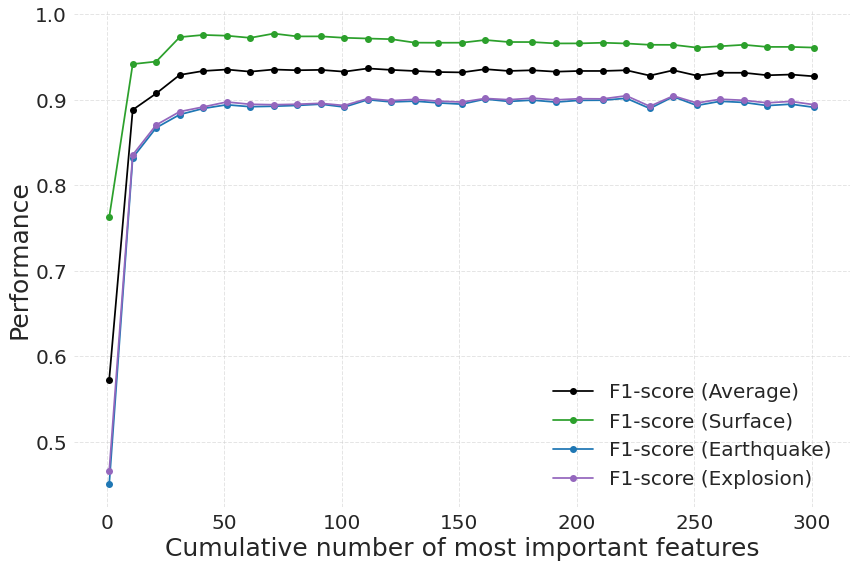

In [36]:
# Create a figure and axis for the main plot
fig, ax = plt.subplots(figsize=[12, 8])



cb_palette = ['#1f77b4','#9467bd',   '#d62728',  '#2ca02c',  ]


# Main plot
ax.plot(np.arange(1, len(sorted_feature_labels), 10), f1_features, marker='o', label='F1-score (Average)', color='k', linestyle='-')
ax.plot(np.arange(1, len(sorted_feature_labels), 10), f1_su, marker='o', label='F1-score (Surface)', color= '#2ca02c', linestyle='-')
ax.plot(np.arange(1, len(sorted_feature_labels), 10), f1_eq, marker='o', label='F1-score (Earthquake)', color='#1f77b4', linestyle='-')
ax.plot(np.arange(1, len(sorted_feature_labels), 10), f1_exp, marker='o', label='F1-score (Explosion)', color= '#9467bd', linestyle='-')
#ax.plot(np.arange(1, len(sorted_feature_labels), 10), f1_features, marker='o', label='F1-score', color=colors(0), linestyle='-')


#ax.plot(np.arange(len(f1_features)), acc_features, marker='s', label='Accuracy', color=colors(1), linestyle='--')
#ax.plot(np.arange(len(f1_features)), prec_features, marker='^', label='Precision', color=colors(2), linestyle='-.')
#ax.plot(np.arange(len(f1_features)), rec_features, marker='d', label='Recall', color=colors(3), linestyle=':')
ax.legend(fontsize= 20, loc='lower right')
ax.set_xlabel('Cumulative number of most important features', fontsize=25)
ax.set_ylabel('Performance', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.grid(True, linestyle='--', alpha=0.5)
#ax.set_title('Performance Metrics vs. Number of Features', fontsize=25)



plt.tight_layout()
plt.show()


## In the following code, we are randomly selecting 5000 "Events" per class,  and separating them from the testing dataset

## First let's remove the events that have different labels assigned by USGS and PNSN, apparently there are 15 such events corresponding to 293 traces

## We will visualize the distribution of  classes in the PNSN event labels 

Text(0.5, 0, 'Labels assigned by PNSN')

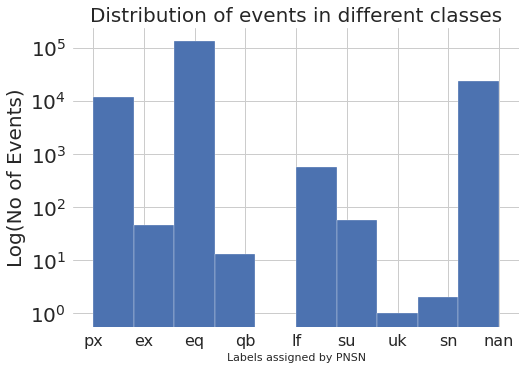

In [37]:
plt.hist(X_final['source_type_pnsn_label'].astype('str'), align = 'mid')
plt.yscale('log')
plt.title('Distribution of events in different classes', fontsize = 20)
plt.ylabel('Log(No of Events)', fontsize = 20)
plt.xlabel('Labels assigned by PNSN')

### Explanation of PNSN labels


- px - probable blast , 'explosion' (USGS)
- ex - confirmed explosion, 'explosion' (USGS)
- eq - earthquake, 'earthquake' (USGS)
- qb - quarry blast, 'explosion' (USGS)
- lf - low frequency earthquakes (USGS)
- su - surface event, 'Surface event' (USGS)
- uk - unknown, 'Earthquake' (USGS)
- sn - 
- nan - noise is not a part of pnsn label

## Selecting 5000 random events (with replacement from gaussian distribution) for the trainining dataset. This does not mean every class contains 5000 rows in the training but 5000 events, and each event may be recorded on different number of stations

In [35]:
## extracting metadata information for each kind of source along with features
## source_type_pnsn_label is more reliable label. 


# selecting all the earthquakes and their metadata information. 
a_eq = X_final[X_final['source_type_pnsn_label'] == 'eq']



## removing the ambiguous events, these are the events that were assigned as earthquakes by pnsn but labelled as
## explosion in USGS ANSS catalog. 
a_eq = a_eq[a_eq['source_type'] != 'explosion']


## selecting all the explosions specifically px, (which is mainly quarry blasts)
a_px = X_final[X_final['source_type_pnsn_label'] == 'px']
# removing the ambiguous events. 
a_px = a_px[a_px['source_type'] != 'earthquake']

a_su = X_final[X_final['source_type'] == 'surface event']
a_no = X_final[X_final['source_type'] == 'noise']



# Extract event IDs for each source type
eq_ids, px_ids, su_ids, no_ids = (
    np.unique(a['event_id'].values) for a in [a_eq, a_px, a_su, a_no]
)



## Specifying a random seed for the reproducibility. 
np.random.seed(123) 


## randomizing along the time. 
r1 = np.random.randint(0, len(eq_ids), 5000)
train_eq = eq_ids[r1]

## randomizing along the time. 
r2 = np.random.randint(0, len(px_ids), 5000)
train_px = px_ids[r2]

## randomizing along the time. 
r3 = np.random.randint(0, len(su_ids), 5000)
train_su = su_ids[r3]

## randomizing along the time
r4 = np.random.randint(0, len(no_ids), 5000)
train_no = no_ids[r4]



mask_eq = np.ones(eq_ids.shape, dtype = bool)
mask_eq[r1] = False

mask_px = np.ones(px_ids.shape, dtype = bool)
mask_px[r2] = False

mask_su = np.ones(su_ids.shape, dtype = bool)
mask_su[r3] = False

mask_no = np.ones(no_ids.shape, dtype = bool)
mask_no[r4] = False

test_eq = eq_ids[mask_eq]
test_px = px_ids[mask_px]
test_su = su_ids[mask_su]
test_no = no_ids[mask_no]



# concatenating training ids
all_train_ids = np.concatenate([train_eq,train_px, train_su, train_no])

# concatenating testing ids
all_test_ids = np.concatenate([test_eq,test_px, test_su, test_no])

# allocating event id as index
X_final.index = X_final['event_id'].values


# extracting training and testing values
X_train = X_final.loc[all_train_ids]
X_test = X_final.loc[all_test_ids]



Y_train = X_train['source_type'].values
Y_test = X_test['source_type'].values

Text(0.5, 1.0, 'Number of events / class in testing dataset')

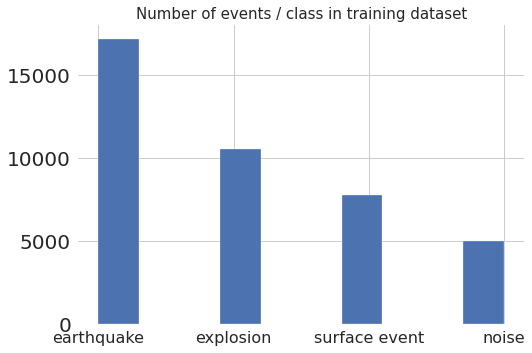

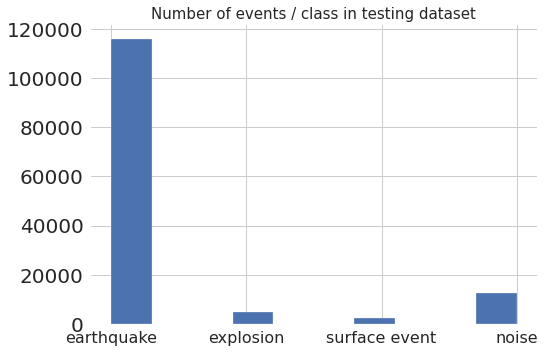

In [36]:
## Visualizing the number of events in each class in training and testing dataset. 
plt.figure()
plt.hist(Y_train)
plt.title('Number of events / class in training dataset', fontsize = 15)


plt.figure()
plt.hist(Y_test)
plt.title('Number of events / class in testing dataset', fontsize = 15)

## We can experiment by removing and adding the manual features in the cell below to see how much they contribute to performance

In [37]:
# Case 1: without adding anything manual
## Check the performance 
x_train = X_train.iloc[:, 0:int(np.where(X_train.columns == 'serial_no')[0])]
#x_train = x_train.assign(hod=X_train['hour_of_day'].values, dow=X_train['day_of_week'].values, moy=X_train['month_of_year'].values)

x_test = X_test.iloc[:, 0:int(np.where(X_train.columns == 'serial_no')[0])]
#x_test = x_test.assign(hod=X_test['hour_of_day'].values, dow=X_test['day_of_week'].values, moy=X_test['month_of_year'].values)



## Training the model on 5000 randomly samples waveforms per class and testing it on the remaining dataset

In [38]:
# initiating a random undersampler
# we have also specified a random state for reproducibility


# number of samples per each event. 
nus = 5000
rus = RandomUnderSampler(sampling_strategy={'earthquake':nus, 'explosion':nus,'surface event':nus,'noise':nus}, random_state = 42)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Converting the textual labels into numerical labels
y_num_test = label_encoder.fit_transform(Y_test)


# randomly taking 5000 samples per class from the training dataset
X_resampled, y_resampled = rus.fit_resample(x_train, Y_train)


# Fit the LabelEncoder on the text labels and transform them to numeric labels
y_num_res = label_encoder.fit_transform(y_resampled)



best_model.class_weight  = None
best_model.fit(X_resampled, y_num_res)




RandomForestClassifier(bootstrap=False, n_estimators=500, random_state=42)

## Trace wise performance

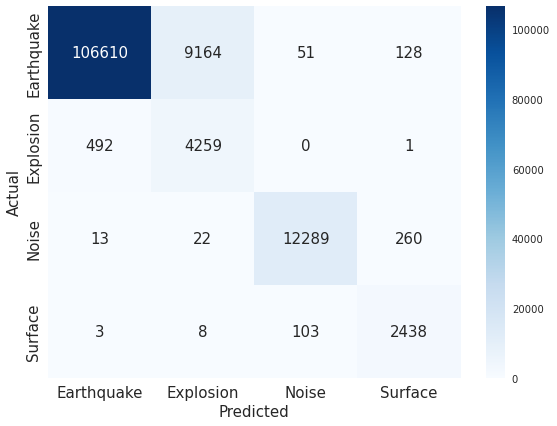

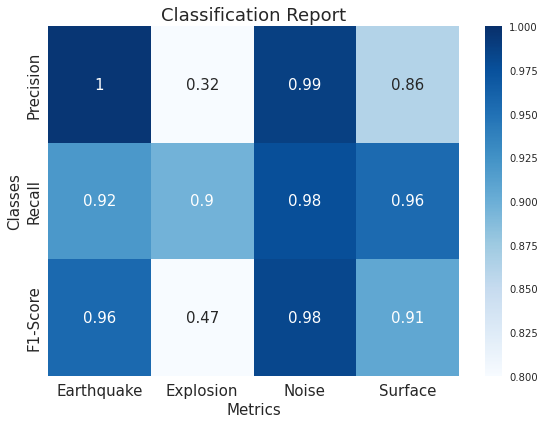

In [40]:
y_pred = best_model.predict(x_test)
plt.style.use('seaborn')
trace_cm_phy_tsf = confusion_matrix(y_num_test, y_pred)
plot_confusion_matrix(trace_cm_phy_tsf)


# Calculate the classification report
trace_report_phy_tsf = classification_report(y_num_test, y_pred, output_dict=True)
plot_classification_report(trace_report_phy_tsf)


## Event wise performance

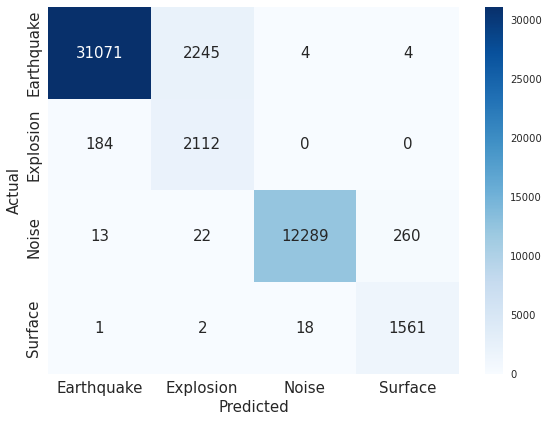

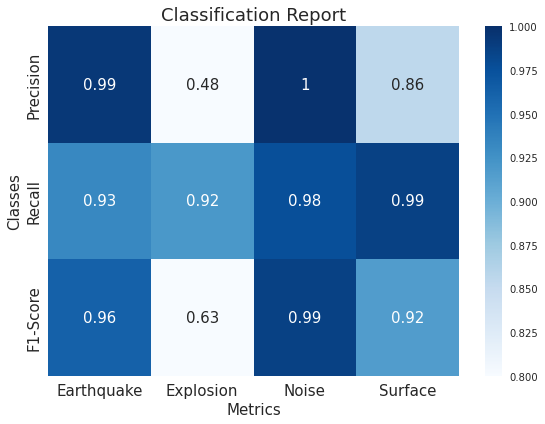

In [41]:
probs_all = best_model.predict_proba(x_test)

X_test['labelled'] = y_num_test
X_test['classified'] = y_pred
X_test['eq_probability'] = probs_all[:,0]
X_test['px_probability'] = probs_all[:,1]
X_test['no_probability'] = probs_all[:,2]
X_test['su_probability'] = probs_all[:,3]


mean_labels = X_test.groupby('event_id').mean()['labelled'].values
mean_ids = X_test.groupby('event_id').mean().index.values



mean_eq_prob = X_test.groupby('event_id').mean()['eq_probability'].values
mean_px_prob = X_test.groupby('event_id').mean()['px_probability'].values
mean_no_prob = X_test.groupby('event_id').mean()['no_probability'].values
mean_su_prob = X_test.groupby('event_id').mean()['su_probability'].values



temp_class = np.argmax(np.vstack([mean_eq_prob, mean_px_prob, mean_no_prob, mean_su_prob]), axis = 0)
temp_probs = np.max(np.vstack([mean_eq_prob, mean_px_prob, mean_no_prob, mean_su_prob]), axis = 0)



cf_events_phy_tsf = confusion_matrix(mean_labels, temp_class)
plot_confusion_matrix(cf_events_phy_tsf)


# Calculate the classification report
report_event_phy_tsf = classification_report(mean_labels, temp_class, output_dict=True)
plot_classification_report(report_event_phy_tsf)


### Performance after adding Manual Features (HOD, DOW, MOY)

In [42]:
# Case 1: without adding anything manual
## Check the performance 
x_train = X_train.iloc[:, 0:int(np.where(X_train.columns == 'serial_no')[0])]
x_train = x_train.assign(hod=X_train['hour_of_day'].values, dow=X_train['day_of_week'].values, moy=X_train['month_of_year'].values)

x_test = X_test.iloc[:, 0:int(np.where(X_train.columns == 'serial_no')[0])]
x_test = x_test.assign(hod=X_test['hour_of_day'].values, dow=X_test['day_of_week'].values, moy=X_test['month_of_year'].values)



In [43]:
# initiating a random undersampler
rus = RandomUnderSampler(sampling_strategy={'earthquake':5000, 'explosion':5000,'surface event':5000,'noise':5000}, random_state = 42)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Converting the textual labels into numerical labels
y_num_test = label_encoder.fit_transform(Y_test)


# randomly taking 5000 samples per class from the training dataset
X_resampled, y_resampled = rus.fit_resample(x_train, Y_train)


# Fit the LabelEncoder on the text labels and transform them to numeric labels
y_num_res = label_encoder.fit_transform(y_resampled)



best_model.class_weight  = None
best_model.fit(X_resampled, y_num_res)




RandomForestClassifier(bootstrap=False, n_estimators=500, random_state=42)

## Trace wise performance

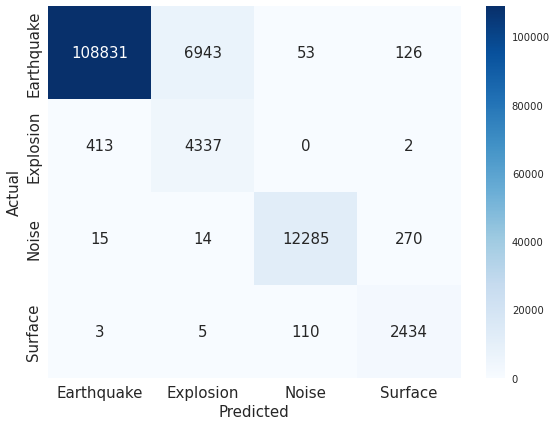

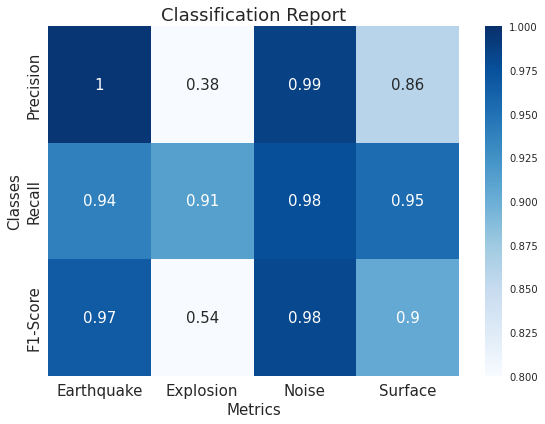

In [44]:
## Plotting the confusion matrix
y_pred = best_model.predict(x_test)
plt.style.use('seaborn')
trace_cm_phy_tsf_man = confusion_matrix(y_num_test, y_pred)
plot_confusion_matrix(trace_cm_phy_tsf_man)



# Plotting the classification report
trace_report_phy_tsf_man = classification_report(y_num_test, y_pred, output_dict=True)
plot_classification_report(trace_report_phy_tsf_man)



## Event Wise Performance

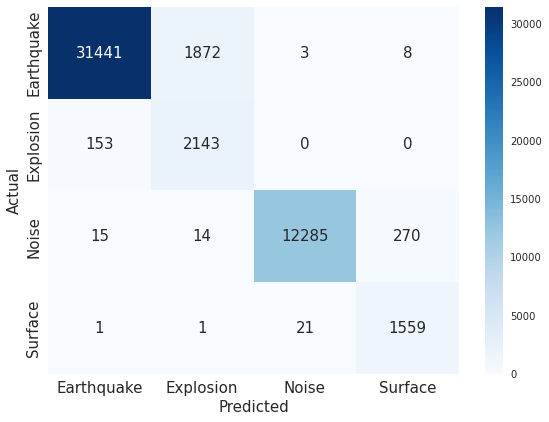

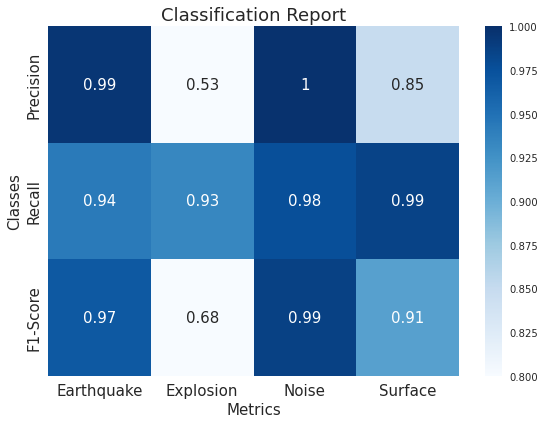

In [45]:
probs_all = best_model.predict_proba(x_test)

X_test['labelled'] = y_num_test
X_test['classified'] = y_pred
X_test['eq_probability'] = probs_all[:,0]
X_test['px_probability'] = probs_all[:,1]
X_test['no_probability'] = probs_all[:,2]
X_test['su_probability'] = probs_all[:,3]


mean_labels = X_test.groupby('event_id').mean()['labelled'].values
mean_ids = X_test.groupby('event_id').mean().index.values



mean_eq_prob = X_test.groupby('event_id').mean()['eq_probability'].values
mean_px_prob = X_test.groupby('event_id').mean()['px_probability'].values
mean_no_prob = X_test.groupby('event_id').mean()['no_probability'].values
mean_su_prob = X_test.groupby('event_id').mean()['su_probability'].values



## Assigning an event class based on the maximum average probability across the stations. 
temp_class = np.argmax(np.vstack([mean_eq_prob, mean_px_prob, mean_no_prob, mean_su_prob]), axis = 0)
## Computing the maximum averaged probability. 
temp_probs = np.max(np.vstack([mean_eq_prob, mean_px_prob, mean_no_prob, mean_su_prob]), axis = 0)



## Plotting the confusion matrix
cf_events_phy_tsf_man = confusion_matrix(mean_labels, temp_class)
#cf_norm = cf_events/np.sum(cf_events, axis = 1, keepdims = True)
plot_confusion_matrix(cf_events_phy_tsf_man)



# Plotting the classification report
report_event_phy_tsf_man = classification_report(mean_labels, temp_class, output_dict=True)
plot_classification_report(report_event_phy_tsf_man)

## Saving results of different models

In [46]:
# Saving every result into disk

# Saving trace results

## physical + tsfel
# Save to a file
with open('../results/trace_report_phy_tsf.pkl', 'wb') as pickle_file:
    pickle.dump(trace_report_phy_tsf, pickle_file)

    
# Save to a file
with open('../results/trace_confusion_matrix_phy_tsf.pkl', 'wb') as pickle_file:
    pickle.dump(trace_cm_phy_tsf, pickle_file)
    
    

# Saving event results

with open('../results/event_report_phy_tsf.pkl', 'wb') as pickle_file:
    pickle.dump(report_event_phy_tsf, pickle_file)

    

with open('../results/event_confusion_matrix_phy_tsf.pkl', 'wb') as pickle_file:
    pickle.dump(cf_events_phy_tsf, pickle_file)

    
    
## physical + tsfel + manual
    
    
# Save to a file
with open('../results/trace_report_phy_tsf_man.pkl', 'wb') as pickle_file:
    pickle.dump(trace_report_phy_tsf_man, pickle_file)

    
# Save to a file
with open('../results/trace_confusion_matrix_phy_tsf_man.pkl', 'wb') as pickle_file:
    pickle.dump(trace_cm_phy_tsf_man, pickle_file)
    
    

# Saving event results

with open('../results/event_report_phy_tsf_man.pkl', 'wb') as pickle_file:
    pickle.dump(report_event_phy_tsf_man, pickle_file)

    

with open('../results/event_confusion_matrix_phy_tsf_man.pkl', 'wb') as pickle_file:
    pickle.dump(cf_events_phy_tsf_man, pickle_file)

## Saving the trained model 

In [47]:
dump(best_model, '../results/best_rf_model_all_features_50_100.joblib')

['../results/best_rf_model_all_features_50_100.joblib']

## Saving the dataset on which the model was trained 

In [48]:
## saving the final outlier removed dataset for ease of comparison among different features.
X_final.to_csv('../results/common_dataset.csv')

In [49]:
## Saving the common testing dataset
X_test.to_csv('../results/common_test_dataset.csv')

In [50]:
## Saving the common 
X_train.to_csv('../results/common_train_dataset.csv')

In [51]:
X_train

,RappMaxMean,RappMaxMedian,AsDec,KurtoSig,KurtoEnv,SkewSig,SkewEnv,CorPeakNumber,Energy1/3Cor,Energy2/3Cor,int_ratio,MeanFFT,MaxFFT,FMaxFFT,MedianFFT,VarFFT,FCentroid,Fquart3,NPeakFFT,MeanPeaksFFT,E2FFT,E3FFT,E4FFT,KurtoMaxDFT,KurtoMedianDFT,MaxOverMeanDFT,MaxOverMedianDFT,NbrPeaksMaxDFT,NbrPeaksMeanDFT,NbrPeaksMedianDFT,45/46,45/47,NbrPeaksCentralFreq,NbrPeaksMaxFreq,50/51,DistMaxMeanFreqDTF,DistQ2Q1DFT,DistQ3Q2DFT,DistQ3Q1DFT,Peak_Envelope_Amplitude,Average_Envelope_Amplitude,Envelope_Rise_Time,E_0.1_1,Kurto_0.1_1,E_1_3,Kurto_1_3,E_3_10,E_10_20,Kurto_10_20,0_FFT mean coefficient_0,0_FFT mean coefficient_1,0_FFT mean coefficient_2,0_FFT mean coefficient_3,0_FFT mean coefficient_4,0_FFT mean coefficient_5,0_FFT mean coefficient_6,0_FFT mean coefficient_7,0_FFT mean coefficient_8,0_FFT mean coefficient_9,0_FFT mean coefficient_10,0_FFT mean coefficient_11,0_FFT mean coefficient_12,0_FFT mean coefficient_13,0_FFT mean coefficient_14,0_FFT mean coefficient_15,0_FFT mean coefficient_16,0_FFT mean coefficient_17,0_FFT mean coefficient_18,0_FFT mean coefficient_19,0_FFT mean coefficient_20,0_FFT mean coefficient_21,0_FFT mean coefficient_22,0_FFT mean coefficient_23,0_FFT mean coefficient_24,0_FFT mean coefficient_25,0_FFT mean coefficient_26,0_FFT mean coefficient_27,0_FFT mean coefficient_28,0_FFT mean coefficient_29,0_FFT mean coefficient_30,0_FFT mean coefficient_31,0_FFT mean coefficient_32,0_FFT mean coefficient_33,0_FFT mean coefficient_34,0_FFT mean coefficient_35,0_FFT mean coefficient_36,0_FFT mean coefficient_37,0_FFT mean coefficient_38,0_FFT mean coefficient_39,0_FFT mean coefficient_40,0_FFT mean coefficient_41,0_FFT mean coefficient_42,0_FFT mean coefficient_43,0_FFT mean coefficient_44,0_FFT mean coefficient_45,0_FFT mean coefficient_46,0_FFT mean coefficient_47,0_FFT mean coefficient_48,0_FFT mean coefficient_49,0_FFT mean coefficient_50,0_FFT mean coefficient_51,0_FFT mean coefficient_52,0_FFT mean coefficient_53,0_FFT mean coefficient_54,0_FFT mean coefficient_55,0_FFT mean coefficient_56,0_FFT mean coefficient_57,0_FFT mean coefficient_58,0_FFT mean coefficient_59,0_FFT mean coefficient_60,0_FFT mean coefficient_61,0_FFT mean coefficient_62,0_FFT mean coefficient_63,0_FFT mean coefficient_64,0_FFT mean coefficient_65,0_FFT mean coefficient_66,0_FFT mean coefficient_67,0_FFT mean coefficient_68,0_FFT mean coefficient_69,0_FFT mean coefficient_70,0_FFT mean coefficient_71,0_FFT mean coefficient_72,0_FFT mean coefficient_73,0_FFT mean coefficient_74,0_FFT mean coefficient_75,0_FFT mean coefficient_76,0_FFT mean coefficient_77,0_FFT mean coefficient_78,0_FFT mean coefficient_79,0_FFT mean coefficient_80,0_FFT mean coefficient_81,0_FFT mean coefficient_82,0_FFT mean coefficient_83,0_FFT mean coefficient_84,0_FFT mean coefficient_85,0_FFT mean coefficient_86,0_FFT mean coefficient_87,0_FFT mean coefficient_88,0_FFT mean coefficient_89,0_FFT mean coefficient_90,0_FFT mean coefficient_91,0_FFT mean coefficient_92,0_FFT mean coefficient_93,0_FFT mean coefficient_94,0_FFT mean coefficient_95,0_FFT mean coefficient_96,0_FFT mean coefficient_98,0_FFT mean coefficient_99,0_FFT mean coefficient_100,0_FFT mean coefficient_101,0_FFT mean coefficient_102,0_FFT mean coefficient_103,0_FFT mean coefficient_104,0_FFT mean coefficient_105,0_FFT mean coefficient_106,0_FFT mean coefficient_107,0_FFT mean coefficient_113,0_FFT mean coefficient_114,0_FFT mean coefficient_116,0_FFT mean coefficient_117,0_FFT mean coefficient_118,0_FFT mean coefficient_125,0_FFT mean coefficient_126,0_FFT mean coefficient_127,0_FFT mean coefficient_128,0_FFT mean coefficient_129,0_FFT mean coefficient_130,0_FFT mean coefficient_131,0_FFT mean coefficient_132,0_FFT mean coefficient_133,0_FFT mean coefficient_134,0_FFT mean coefficient_135,0_FFT mean coefficient_136,0_FFT mean coefficient_137,0_FFT mean coefficient_138,0_FFT mean coefficient_139,0_FFT mean coefficient_140,0_FFT mean coefficient_141,0_FFT mean coefficient_142,0_FFT mean coefficient_143,0_FFT m

## Analysing Misclassified Events

In [ ]:
# probabilities corresponding to misclassified events
misclassified_probs = temp_probs[np.where(mean_labels != temp_class)]

# classification provided to misclassified events
misclassified_class = temp_class[np.where(mean_labels != temp_class)]

# labels provided to misclassified events. 
misclassified_labels = mean_labels[np.where(mean_labels != temp_class)]

# event ids provided to misclassified events. 
misclassified_ids = mean_ids[np.where(mean_labels != temp_class)]

# event ids from misclassified events where mean probabilities exceed 0.8
misclassified_high_prob = misclassified_ids[np.where(misclassified_probs > 0.8)]


# Dataframe of misclassified events
misclassified_X = X_test.loc[misclassified_high_prob]



In [ ]:
## Finding mislabelled events for each class
miss_exp = misclassified_X[misclassified_X['source_type'] == 'explosion']
miss_eq = misclassified_X[misclassified_X['source_type'] == 'earthquake']
miss_su = misclassified_X[misclassified_X['source_type'] == 'surface event']
miss_no = misclassified_X[misclassified_X['source_type'] == 'noise']

In [ ]:
miss_exp.to_csv('../results/missclassified_explosions_with_80.csv')
miss_eq.to_csv('../results/missclassified_earthquake_with_80.csv')
miss_su.to_csv('../results/missclassified_surface_with_80.csv')
miss_no.to_csv('../results/missclassified_noise_with_80.csv')

In [ ]:
miss_exp

## Misclassified Explosions

In [ ]:
## Finding mislabelled events for each class
miss_exp = misclassified_X[misclassified_X['source_type'] == 'explosion']
miss_eq = misclassified_X[misclassified_X['source_type'] == 'earthquake']
miss_su = misclassified_X[misclassified_X['source_type'] == 'surface event']
miss_no = misclassified_X[misclassified_X['source_type'] == 'noise']

## extracting data
p_arrivals= miss_exp['trace_P_arrival_sample'].values  ## We have P arrivals for the comcat events. 
buck_exp = [miss_exp['trace_name'].values[i].split('$')[0] for i in range(len(miss_exp))]
ind_exp = [int(miss_exp['trace_name'].values[i].split('$')[1].split(',')[0]) for i in range(len(miss_exp))]


## loading the data
data_exp = []
for i in range(len(buck_exp)):
    data_exp.append(comcat_file_name['/data/'+buck_exp[i]][ind_exp[i], 2, :15000])
    

## Processing the data
## This is to show the input before extracting features. 
data_exp = np.array(data_exp)

# Applying 10% cosine taper
tapered_exp = apply_cosine_taper(data_exp)

# Applying bandpass filter 1-10 Hz. (4 cornered)
final_exp = butterworth_filter(tapered_exp, 1, 10, 100, 4)

# Normalizing the data to remove the instrumental effect
norm_exp = final_exp/np.max(abs(np.array(final_exp)), axis = 1).reshape(-1,1)




## Assigning colors to each event id
# Example list of unique values
unique_values = miss_exp['event_id'].values# Your list here

# Choose a color palette
palette = sns.color_palette("dark", n_colors=len(unique_values))

# Create a mapping of unique values to colors
value_to_color = {value: color for value, color in zip(unique_values, palette)}

# Assign colors to the values
colors_list = [value_to_color[value] for value in unique_values]



labels = ['earthquake','explosion','noise','surface events']

#norm_exp = norm_exp[0:25]
#miss_exp = miss_exp[0:25]

## Assigned class and the probability
miss_exp_probs = np.max(miss_exp.loc[:,['eq_probability','px_probability', 'no_probability','su_probability']], axis = 1)
numerical_labels = np.argmax(miss_exp.loc[:,['eq_probability','px_probability', 'no_probability','su_probability']].values, axis = 1)
cat_labels = [labels[numerical_labels[i]] for i in range(len(numerical_labels))]
miss_ids = miss_exp['event_id'].values
miss_stns = (miss_exp['station_network_code']+'.'+miss_exp['station_code']+'.'+miss_exp['station_channel_code']+'Z').values

In [ ]:

sns.set_style('whitegrid')

# Set rc parameters for font size
plt.rcParams['xtick.labelsize'] = 20  # Font size for xtick labels
plt.rcParams['ytick.labelsize'] = 20  # Font size for ytick labels
plt.rcParams['axes.labelsize'] = 18   # Font size for axis labels
plt.rcParams['axes.titlesize'] = 18   # Font size for title



# Create a figure and axes
fig, ax = plt.subplots(figsize=[15, 18])

# Plot the data with customized colors

for i in range(len(norm_exp)):
    t = np.linspace(1, len(np.array(norm_exp[i])[int(p_arrivals[i]) - 5000:])/100, len(np.array(norm_exp[i])[int(p_arrivals[i]) - 5000:]))
    ax.plot(t, np.array(norm_exp[i])[int(p_arrivals[i]) - 5000:] + i, lw=0.5, c=colors_list[i])
    ax.set_xlim(20, 90)
# Set y-axis labels
ax.set_yticks(ticks=np.arange(len(norm_exp)))
#ax.set_yticklabels(
#    labels=[miss_exp['source_type'].values[i] for i in range(len(miss_exp))],
#    fontsize = 15)

ax.set_yticks([])

# Set plot title and labels
#ax.set_title('Misclassified Explosions (px) with Mean Probabilities Exceeding 0.8', fontsize=25)
#ax.set_ylabel('PNSN labels Explosions', fontsize=25)
ax.grid(False)

# Create a twin axis on the right side
#ax2 = ax.twinx()
#ax2.set_yticks(np.arange(len(norm_exp)))
#ax2.set_yticklabels(
#    [cat_labels[i] + ', ' + str(np.around(miss_exp_probs[i], 2)) for i in range(len(miss_exp))], fontsize = 15
#   )

for i in range(len(miss_exp)):
    ax.text(90, i+0.2, str(np.around(miss_exp_probs[i],2)),  fontsize = 20)
ax.set_yticklabels([])


ax.text(85, len(miss_exp), 'Predicted Earthquakes', fontsize = 20)
ax.text(40, len(miss_exp), 'PNSN labels Explosions', fontsize = 20)
# Plot the data on the twin axis
#for i in range(len(norm_exp)):
    #t = np.linspace(1, len(np.array(norm_exp[i])[int(p_arrivals[i]) - 3000:])/100, len(np.array(norm_exp[i])[int(p_arrivals[i]) - 3000:]))
    #ax2.plot(t, np.array(norm_exp[i])[int(p_arrivals[i]) - 3000:] + i, lw=0.5, c=colors_list[i])
    #ax2.set_xlim(20)
# Set y-axis label for the twin axis
#ax2.set_ylabel('Predicted Earthquakes', fontsize=25)

# Adjust the positions of both y-axes for alignment
ax.spines['right'].set_visible(False)
#ax2.spines['left'].set_visible(False)
ax.yaxis.tick_left()
#ax2.yaxis.tick_right()
#ax2.tick_params(labelright=False)

# Set the location of y labels for the twin axis
#ax2.yaxis.set_label_position('right')
#ax2.yaxis.set_ticks_position('right')

ax.set_xlim(40, 100)
ax.set_xlabel('Time (s)')
# Remove grid lines
plt.grid(False)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
plt.scatter(miss_exp['source_longitude_deg'].values, miss_exp['source_latitude_deg'].values)
plt.scatter(miss_eq['source_longitude_deg'].values, miss_eq['source_latitude_deg'].values, alpha = 0.5)

## Plotting misclassified earthquakes

In [ ]:
## Finding mislabelled events for each class
miss_exp = misclassified_X[misclassified_X['source_type'] == 'explosion']
miss_eq = misclassified_X[misclassified_X['source_type'] == 'earthquake']
miss_su = misclassified_X[misclassified_X['source_type'] == 'surface event']
miss_no = misclassified_X[misclassified_X['source_type'] == 'noise']

miss_eq = miss_eq[25:50]

## extracting data
p_arrivals= miss_eq['trace_P_arrival_sample'].values  ## We have P arrivals for the comcat events. 
buck_eq = [miss_eq['trace_name'].values[i].split('$')[0] for i in range(len(miss_eq))]
ind_eq = [int(miss_eq['trace_name'].values[i].split('$')[1].split(',')[0]) for i in range(len(miss_eq))]


## loading the data
data_eq = []
for i in range(len(buck_eq)):
    data_eq.append(comcat_file_name['/data/'+buck_eq[i]][ind_eq[i], 2, :15000])
    

## Processing the data
## This is to show the input before extracting features. 
data_eq = np.array(data_eq)

# Applying 10% cosine taper
tapered_eq = apply_cosine_taper(data_eq)

# Applying bandpass filter 1-10 Hz. (4 cornered)
final_eq = butterworth_filter(tapered_eq, 1, 10, 100, 4)

# Normalizing the data to remove the instrumental effect
norm_eq = final_eq/np.max(abs(np.array(final_eq)), axis = 1).reshape(-1,1)




## Assigning colors to each event id
# Example list of unique values
unique_values = miss_eq['event_id'].values# Your list here

# Choose a color palette
palette = sns.color_palette("dark", n_colors=len(unique_values))

# Create a mapping of unique values to colors
value_to_color = {value: color for value, color in zip(unique_values, palette)}

# Assign colors to the values
colors_list = [value_to_color[value] for value in unique_values]



labels = ['earthquake','explosion','noise','surface events']



## Assigned class and the probability
miss_eq_probs = np.max(miss_eq.loc[:,['eq_probability','px_probability', 'no_probability','su_probability']], axis = 1)
numerical_labels = np.argmax(miss_eq.loc[:,['eq_probability','px_probability', 'no_probability','su_probability']].values, axis = 1)
cat_labels = [labels[numerical_labels[i]] for i in range(len(numerical_labels))]
miss_ids = miss_eq['event_id'].values
miss_stns = (miss_eq['station_network_code']+'.'+miss_eq['station_code']+'.'+miss_eq['station_channel_code']+'Z').values

In [ ]:

sns.set_style('whitegrid')

# Set rc parameters for font size
plt.rcParams['xtick.labelsize'] = 20  # Font size for xtick labels
plt.rcParams['ytick.labelsize'] = 20  # Font size for ytick labels
plt.rcParams['axes.labelsize'] = 18   # Font size for axis labels
plt.rcParams['axes.titlesize'] = 18   # Font size for title



# Create a figure and axes
fig, ax = plt.subplots(figsize=[15, 18])

# Plot the data with customized colors

for i in range(len(norm_eq)):
    t = np.linspace(1, len(np.array(norm_eq[i])[int(p_arrivals[i]) - 5000:])/100, len(np.array(norm_eq[i])[int(p_arrivals[i]) - 5000:]))
    ax.plot(t, np.array(norm_eq[i])[int(p_arrivals[i]) - 5000:] + i, lw=0.5, c=colors_list[i])
    ax.set_xlim(20, 90)
# Set y-axis labels
ax.set_yticks(ticks=np.arange(len(norm_eq)))
#ax.set_yticklabels(
#    labels=[miss_exp['source_type'].values[i] for i in range(len(miss_exp))],
#    fontsize = 15)

ax.set_yticks([])

# Set plot title and labels
#ax.set_title('Misclassified Explosions (px) with Mean Probabilities Exceeding 0.8', fontsize=25)
#ax.set_ylabel('PNSN labels Explosions', fontsize=25)
ax.grid(False)

# Create a twin axis on the right side
#ax2 = ax.twinx()
#ax2.set_yticks(np.arange(len(norm_exp)))
#ax2.set_yticklabels(
#    [cat_labels[i] + ', ' + str(np.around(miss_exp_probs[i], 2)) for i in range(len(miss_exp))], fontsize = 15
#   )

for i in range(len(miss_eq)):
    ax.text(90, i+0.2, str(np.around(miss_eq_probs[i],2)),  fontsize = 20)
ax.set_yticklabels([])


ax.text(85, 25, 'Predicted Explosions', fontsize = 20)
ax.text(40, 25, 'PNSN labels Earthquakes', fontsize = 20)
# Plot the data on the twin axis
#for i in range(len(norm_exp)):
    #t = np.linspace(1, len(np.array(norm_exp[i])[int(p_arrivals[i]) - 3000:])/100, len(np.array(norm_exp[i])[int(p_arrivals[i]) - 3000:]))
    #ax2.plot(t, np.array(norm_exp[i])[int(p_arrivals[i]) - 3000:] + i, lw=0.5, c=colors_list[i])
    #ax2.set_xlim(20)
# Set y-axis label for the twin axis
#ax2.set_ylabel('Predicted Earthquakes', fontsize=25)

# Adjust the positions of both y-axes for alignment
ax.spines['right'].set_visible(False)
#ax2.spines['left'].set_visible(False)
ax.yaxis.tick_left()
#ax2.yaxis.tick_right()
#ax2.tick_params(labelright=False)

# Set the location of y labels for the twin axis
#ax2.yaxis.set_label_position('right')
#ax2.yaxis.set_ticks_position('right')

ax.set_xlim(40, 100)
ax.set_xlabel('Time (s)')
# Remove grid lines
plt.grid(False)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Plotting misclassified noise

In [ ]:
## Assigned class and the probability
miss_no_probs = np.max(miss_no.loc[:,['eq_probability','px_probability', 'no_probability','su_probability']], axis = 1)
## extracting data

buck_no = [miss_no['trace_name'].values[i].split('$')[0] for i in range(len(miss_no))]
ind_no = [int(miss_no['trace_name'].values[i].split('$')[1].split(',')[0]) for i in range(len(miss_no))]


## loading the data
data_no = []
for i in range(len(buck_no)):
    data_no.append(comcat_file_name['/data/'+buck_no[i]][ind_no[i], 2, :15000])
    

## Processing the data
## This is to show the input before extracting features. 
data_no = np.array(data_no)

# Applying 10% cosine taper
tapered_no = apply_cosine_taper(data_no)

# Applying bandpass filter 1-10 Hz. (4 cornered)
final_no = butterworth_filter(tapered_no, 1, 10, 100, 4)

# Normalizing the data to remove the instrumental effect
norm_no = final_no/np.max(abs(np.array(final_no)), axis = 1).reshape(-1,1)



## Assigning colors to each event id
# Example list of unique values
unique_values = miss_no['event_id'].values# Your list here


# Choose a color palette
palette = sns.color_palette("dark", n_colors=len(unique_values))

# Create a mapping of unique values to colors
value_to_color = {value: color for value, color in zip(unique_values, palette)}

# Assign colors to the values
colors_list = [value_to_color[value] for value in unique_values]



labels = ['earthquake','explosion','noise','surface events']






sns.set_style('whitegrid')

# Set rc parameters for font size
plt.rcParams['xtick.labelsize'] = 20  # Font size for xtick labels
plt.rcParams['ytick.labelsize'] = 20  # Font size for ytick labels
plt.rcParams['axes.labelsize'] = 18   # Font size for axis labels
plt.rcParams['axes.titlesize'] = 18   # Font size for title



# Create a figure and axes
fig, ax = plt.subplots(figsize=[15, 25])

# Plot the data with customized colors

for i in range(len(norm_no)):
    t = np.linspace(1, len(np.array(norm_no[i]))/100, len(np.array(norm_no[i])))
    ax.plot(t, np.array(norm_no[i]) + i, lw=0.5, c=colors_list[i])
    ax.set_xlim(20, 90)
# Set y-axis labels
ax.set_yticks(ticks=np.arange(len(norm_no)))
#ax.set_yticklabels(
#    labels=[miss_exp['source_type'].values[i] for i in range(len(miss_exp))],
#    fontsize = 15)

ax.set_yticks([])

# Set plot title and labels
#ax.set_title('Misclassified Explosions (px) with Mean Probabilities Exceeding 0.8', fontsize=25)
#ax.set_ylabel('PNSN labels Explosions', fontsize=25)
ax.grid(False)

# Create a twin axis on the right side
#ax2 = ax.twinx()
#ax2.set_yticks(np.arange(len(norm_exp)))
#ax2.set_yticklabels(
#    [cat_labels[i] + ', ' + str(np.around(miss_exp_probs[i], 2)) for i in range(len(miss_exp))], fontsize = 15
#   )

for i in range(len(miss_no)):
    ax.text(90, i+0.2, str(np.around(miss_no_probs[i],2)),  fontsize = 20)
ax.set_yticklabels([])


ax.text(85, len(miss_no), 'Predicted Surface Events', fontsize = 20)
ax.text(40, len(miss_no), 'Noise samples', fontsize = 20)
# Plot the data on the twin axis
#for i in range(len(norm_exp)):
    #t = np.linspace(1, len(np.array(norm_exp[i])[int(p_arrivals[i]) - 3000:])/100, len(np.array(norm_exp[i])[int(p_arrivals[i]) - 3000:]))
    #ax2.plot(t, np.array(norm_exp[i])[int(p_arrivals[i]) - 3000:] + i, lw=0.5, c=colors_list[i])
    #ax2.set_xlim(20)
# Set y-axis label for the twin axis
#ax2.set_ylabel('Predicted Earthquakes', fontsize=25)

# Adjust the positions of both y-axes for alignment
ax.spines['right'].set_visible(False)
#ax2.spines['left'].set_visible(False)
ax.yaxis.tick_left()
#ax2.yaxis.tick_right()
#ax2.tick_params(labelright=False)

# Set the location of y labels for the twin axis
#ax2.yaxis.set_label_position('right')
#ax2.yaxis.set_ticks_position('right')

ax.set_xlim(40, 100)
ax.set_xlabel('Time (s)')
# Remove grid lines
plt.grid(False)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Plotting the event depth distribution of the misclassified event catalog

In [ ]:
miss_eq['event_id'] = miss_eq.index.values
plt.figure(figsize=(10, 6))
sns.histplot(data=miss_eq.groupby('event_id').mean()['source_depth_km'], bins=20, kde=False, color='skyblue')
plt.xlabel('Source Depth (Km)', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)
plt.title('Misclassified Earthquakes with High Probabilities (>0.8)', fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()



miss_exp['event_id'] = miss_exp.index.values
plt.figure(figsize=(10, 6))
sns.histplot(data=miss_exp.groupby('event_id').mean()['source_depth_km'], bins=20, kde=False, color='skyblue')
plt.xlabel('Source Depth (Km)', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)
plt.title('Misclassified Explosion with High Probabilities (>0.8)', fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

## Computing the distance from the nearest mine/quarry location 

The list may not be very complete but we will work with what we have. 

In [ ]:
# Open the text file for reading and the CSV file for writing
with open('../Common_Scripts/Quarry_Locations.txt', 'r') as infile, open('../Common_Scripts/Quarry_Location.csv', 'w', newline='') as outfile:
    # Create a CSV writer object
    csv_writer = csv.writer(outfile)
    
    # Iterate over each line in the text file
    for line in infile:
        # Split the line into fields using comma as the delimiter
        fields = line.strip().split(',')
        # Write the fields to the CSV file
        csv_writer.writerow(fields)


In [ ]:
## Reading the quarry locations
quarry_df = pd.read_csv('../common_scripts/Quarry_Location.csv', header = None)



miss_eq_lons = miss_eq.groupby('event_id').mean()['source_longitude_deg'].values
miss_eq_lats = miss_eq.groupby('event_id').mean()['source_latitude_deg'].values

miss_exp_lons = miss_exp.groupby('event_id').mean()['source_longitude_deg'].values
miss_exp_lats = miss_exp.groupby('event_id').mean()['source_latitude_deg'].values


# Sample DataFrame with latitude and longitude columns
data = {
    'latitude': quarry_df[1].values,
    'longitude': quarry_df[2].values
}
quarry_loc_df = pd.DataFrame(data)


min_quarry_eq = []

for i in range(len(miss_eq_lats)):
    # Given coordinate
    given_coord = (miss_eq_lats[i], miss_eq_lons[i])  # Example coordinate

 

    # Compute distance between given coordinate and all coordinates in the DataFrame
    dist = quarry_loc_df.apply(lambda row: calculate_distance(given_coord[0], given_coord[1], row['latitude'], row['longitude']), axis=1)


    
    # computing the distance of each event from the closest quarry
    min_quarry_eq.append(np.min(dist))


    
    
min_quarry_exp = []

for i in range(len(miss_exp_lats)):
    # Given coordinate
    given_coord = (miss_exp_lats[i], miss_exp_lons[i])  # Example coordinate

    # Compute distance between given coordinate and all coordinates in the DataFrame
    dist = quarry_loc_df.apply(lambda row: calculate_distance(given_coord[0], given_coord[1], row['latitude'], row['longitude']), axis=1)
    
    # computing the distance of each event from the closest quarry
    min_quarry_exp.append(np.min(dist))


## Plotting the distance from nearest quarry

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data= min_quarry_eq, bins=20, kde=False, color='skyblue')
plt.xlabel('Distance from the nearest quarry (Km)', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)
plt.title('Misclassified Earthquakes with High Probabilities (>0.8)', fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()




plt.figure(figsize=(10, 6))
sns.histplot(data= min_quarry_exp, bins=20, kde=False, color='skyblue')
plt.xlabel('Distance from nearest quarry (Km)', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)
plt.title('Misclassified Explosion with High Probabilities (>0.8)', fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [ ]:
# Scatter plot with prettified features
plt.figure(figsize=(10, 6))
plt.scatter(miss_eq.groupby('event_id').mean()['source_depth_km'], min_quarry_eq, s = 100, color='b', marker='o', edgecolor = 'k', edgecolors='k')
plt.xlabel('Depth (km)')
plt.ylabel('Distance to the nearest quarry (km)')
plt.title('Misclassified Earthquakes with prob > 0.8')
plt.grid(True)
plt.show()



In [ ]:
mean_miss_eq = miss_eq.groupby('event_id').mean()
mean_miss_eq['dist_to_quarry'] = min_quarry_eq

In [ ]:
## Finding for which earthquakes depth < 10 km and distance to quarry < 50 Km. 
sample_miss_eq = mean_miss_eq[(mean_miss_eq['source_depth_km'] < 10) & (mean_miss_eq['dist_to_quarry'] < 50) ]

In [ ]:
new_miss_eq = miss_eq.loc[sample_miss_eq.index.values]

## Retraining the catalog after removing the potentially mislabeled events (Events that were misclassified with high probability)

In this following block, I am picking 5000 random "events" (based on the event ids) from each class and puttiing them into training dataset and putting the rest into testing dataset. 




In [ ]:
## extracting metadata information for each kind of source along with features
a_eq = X_final[X_final['source_type_pnsn_label'] == 'eq']
a_px = X_final[X_final['source_type_pnsn_label'] == 'px']
a_su = X_final[X_final['source_type'] == 'surface event']
a_no = X_final[X_final['source_type'] == 'noise']



## extracting the event ids corresponding to each catalog
eq_ids = np.unique(a_eq['event_id'].values)
su_ids = np.unique(a_su['event_id'].values)
no_ids = np.unique(a_no['event_id'].values)
px_ids = np.unique(a_px['event_id'].values)


## defining the events for training and testing in 70:30 ratio


"""

Modifying this section a bit, for a fair comparison to deep neural network. 


train_eq = eq_ids[0:int(0.7*len(eq_ids))]
train_px = px_ids[0:int(0.7*len(px_ids))]
train_su = su_ids[0:int(0.7*len(su_ids))]
train_no = no_ids[0:int(0.7*len(no_ids))]


test_eq = eq_ids[int(0.7*len(eq_ids)):len(eq_ids)]
test_px = px_ids[int(0.7*len(px_ids)):len(px_ids)]
test_su = su_ids[int(0.7*len(su_ids)):len(su_ids)]
test_no = no_ids[int(0.7*len(no_ids)):len(no_ids)]


"""

## Specifying a random seed for the reproducibility. 
np.random.seed(123) 


## randomizing along the time. 
r1 = np.random.randint(0, len(eq_ids), 5000)
train_eq = eq_ids[r1]

## randomizing along the time. 
r2 = np.random.randint(0, len(px_ids), 5000)
train_px = px_ids[r2]

## randomizing along the time. 
r3 = np.random.randint(0, len(su_ids), 5000)
train_su = su_ids[r3]

## randomizing along the time
r4 = np.random.randint(0, len(no_ids), 5000)
train_no = no_ids[r4]



mask_eq = np.ones(eq_ids.shape, dtype = bool)
mask_eq[r1] = False

mask_px = np.ones(px_ids.shape, dtype = bool)
mask_px[r2] = False

mask_su = np.ones(su_ids.shape, dtype = bool)
mask_su[r3] = False

mask_no = np.ones(no_ids.shape, dtype = bool)
mask_no[r4] = False

test_eq = eq_ids[mask_eq]
test_px = px_ids[mask_px]
test_su = su_ids[mask_su]
test_no = no_ids[mask_no]



# concatenating training ids
all_train_ids = np.concatenate([train_eq,train_px, train_su, train_no])

# concatenating testing ids
all_test_ids = np.concatenate([test_eq,test_px, test_su, test_no])

# allocating event id as index
X_final.index = X_final['event_id'].values


# extracting training and testing values
X_train = X_final.loc[all_train_ids]
X_test = X_final.loc[all_test_ids]



Y_train = X_train['source_type'].values
Y_test = X_test['source_type'].values

## So initial strategy is to remove the events that were incorrectly classified with high probability (> 0.8) and retest the events

In [ ]:
# Case 1: without adding anything manual
## Check the performance 
x_train = X_train.iloc[:, 0:int(np.where(X_train.columns == 'serial_no')[0])]
x_train = x_train.assign(hod=X_train['hour_of_day'].values, dow=X_train['day_of_week'].values, moy=X_train['month_of_year'].values)

x_test = X_test.iloc[:, 0:int(np.where(X_train.columns == 'serial_no')[0])]
x_test = x_test.assign(hod=X_test['hour_of_day'].values, dow=X_test['day_of_week'].values, moy=X_test['month_of_year'].values)






## Randomly sampling 5000 traces for each class in the training dataset, train the model on it and test on the remaining dataset

In [ ]:
# initiating a random undersampler
rus = RandomUnderSampler(sampling_strategy={'earthquake':5000, 'explosion':5000,'surface event':5000,'noise':5000}, random_state = 42)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Converting the textual labels into numerical labels
y_num_test = label_encoder.fit_transform(Y_test)


# randomly taking 5000 samples per class from the training dataset
X_resampled, y_resampled = rus.fit_resample(x_train, Y_train)


# Fit the LabelEncoder on the text labels and transform them to numeric labels
y_num_res = label_encoder.fit_transform(y_resampled)



best_model.class_weight  = None
best_model.fit(X_resampled, y_num_res)

## Trace wise performance

In [ ]:
y_pred = best_model.predict(x_test)
plt.style.use('seaborn')
trace_cm_manual = confusion_matrix(y_num_test, y_pred)
plot_confusion_matrix(trace_cm_manual)



# Calculate the classification report
trace_report_manual = classification_report(y_num_test, y_pred, output_dict=True)
plot_classification_report(trace_report_manual)


## Event wise performance

In [ ]:
probs_all = best_model.predict_proba(x_test)

X_test['labelled'] = y_num_test
X_test['classified'] = y_pred
X_test['eq_probability'] = probs_all[:,0]
X_test['px_probability'] = probs_all[:,1]
X_test['no_probability'] = probs_all[:,2]
X_test['su_probability'] = probs_all[:,3]


mean_labels = X_test.groupby('event_id').mean()['labelled'].values
mean_ids = X_test.groupby('event_id').mean().index.values



mean_eq_prob = X_test.groupby('event_id').mean()['eq_probability'].values
mean_px_prob = X_test.groupby('event_id').mean()['px_probability'].values
mean_no_prob = X_test.groupby('event_id').mean()['no_probability'].values
mean_su_prob = X_test.groupby('event_id').mean()['su_probability'].values



temp_class = np.argmax(np.vstack([mean_eq_prob, mean_px_prob, mean_no_prob, mean_su_prob]), axis = 0)
temp_probs = np.max(np.vstack([mean_eq_prob, mean_px_prob, mean_no_prob, mean_su_prob]), axis = 0)



cf_events_manual = confusion_matrix(mean_labels, temp_class)
plot_confusion_matrix(cf_events_manual)


# Calculate the classification report
report_event_manual = classification_report(mean_labels, temp_class, output_dict=True)
plot_classification_report(report_event_manual)

## Analysis of misclassified events

In [ ]:
# probabilities corresponding to misclassified events
misclassified_probs = temp_probs[np.where(mean_labels != temp_class)]

# classification provided to misclassified events
misclassified_class = temp_class[np.where(mean_labels != temp_class)]

# labels provided to misclassified events. 
misclassified_labels = mean_labels[np.where(mean_labels != temp_class)]

# event ids provided to misclassified events. 
misclassified_ids = mean_ids[np.where(mean_labels != temp_class)]

# event ids from misclassified events where mean probabilities exceed 0.8
misclassified_high_prob = misclassified_ids[np.where(misclassified_probs > 0.7)]

misclassified_X = X_test.loc[misclassified_high_prob]



## Retesting with potentially mislabeled events removed this time

In [ ]:
new_X_test = X_test.drop(misclassified_high_prob)
new_x_test = new_X_test.iloc[:, 0:int(np.where(X_train.columns == 'serial_no')[0])]
new_x_test = new_x_test.assign(hod=new_X_test['hour_of_day'].values, dow=new_X_test['day_of_week'].values, moy= new_X_test['month_of_year'].values)

new_Y_test = new_X_test['source_type'].values

## New trace-wise performance

In [ ]:
y_pred = best_model.predict(new_x_test)
plt.style.use('seaborn')


# Converting the textual labels into numerical labels
y_num_test = label_encoder.fit_transform(new_Y_test)

new_trace_cm_manual = confusion_matrix(y_num_test, y_pred)
plot_confusion_matrix(new_trace_cm_manual)

# Calculate the classification report
new_trace_report_manual = classification_report(y_num_test, y_pred, output_dict=True)
plot_classification_report(new_trace_report_manual)




# New event wise performance

In [ ]:
probs_all = best_model.predict_proba(new_x_test)

new_X_test['labelled'] = y_num_test
new_X_test['classified'] = y_pred
new_X_test['eq_probability'] = probs_all[:,0]
new_X_test['px_probability'] = probs_all[:,1]
new_X_test['no_probability'] = probs_all[:,2]
new_X_test['su_probability'] = probs_all[:,3]


mean_labels = new_X_test.groupby('event_id').mean()['labelled'].values
mean_ids = new_X_test.groupby('event_id').mean().index.values



mean_eq_prob = new_X_test.groupby('event_id').mean()['eq_probability'].values
mean_px_prob = new_X_test.groupby('event_id').mean()['px_probability'].values
mean_no_prob = new_X_test.groupby('event_id').mean()['no_probability'].values
mean_su_prob = new_X_test.groupby('event_id').mean()['su_probability'].values



temp_class = np.argmax(np.vstack([mean_eq_prob, mean_px_prob, mean_no_prob, mean_su_prob]), axis = 0)
temp_probs = np.max(np.vstack([mean_eq_prob, mean_px_prob, mean_no_prob, mean_su_prob]), axis = 0)



new_cf_events_manual = confusion_matrix(mean_labels, temp_class)
#new_cf_norm_manual = cf_events_manual/np.sum(cf_events_manual, axis = 1, keepdims = True)
plot_confusion_matrix(new_cf_events_manual)





# Calculate the classification report
new_report_event_manual = classification_report(mean_labels, temp_class, output_dict=True)
plot_classification_report(new_report_event_manual)


## Plotting the difference in performance before and after removing the potentially mislabeled events

In [ ]:
# Data for the first group
eq_trace_f1 = trace_report_manual['0']['f1-score']
exp_trace_f1 = trace_report_manual['1']['f1-score']
no_trace_f1 = trace_report_manual['2']['f1-score']
su_trace_f1 = trace_report_manual['3']['f1-score']

# Data for the second group
new_eq_trace_f1 = new_trace_report_manual['0']['f1-score']
new_exp_trace_f1 = new_trace_report_manual['1']['f1-score']
new_no_trace_f1 = new_trace_report_manual['2']['f1-score']
new_su_trace_f1 = new_trace_report_manual['3']['f1-score']

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(4)
r2 = [x + bar_width for x in r1]

# Plot the bars
# Colorblind-friendly palette
cb_palette = ['#1f77b4','#9467bd',   '#d62728',  '#2ca02c',  ]


plt.figure(figsize=(12, 6))
plt.bar(r1, [eq_trace_f1, exp_trace_f1, no_trace_f1, su_trace_f1], color= cb_palette, width=bar_width, edgecolor='k', label='Old')
plt.bar(r2, [new_eq_trace_f1, new_exp_trace_f1, new_no_trace_f1, new_su_trace_f1], color= cb_palette, hatch='//', width=bar_width, edgecolor='black', label='New')

# Add labels, title, and legend
plt.ylim(0.5,1.25)
plt.xlabel('Classes',  fontsize=25)
plt.ylabel('F1-score', fontsize=25)
plt.xticks([r + bar_width/2 for r in range(4)], ['Earthquake', 'Explosion', 'Noise', 'Surface'], fontsize=20)
#plt.title('F1-score by Class for Old and New', fontweight='bold', fontsize=14)
plt.legend(fontsize=20)

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add value labels on top of each bar
def add_value_labels(ax):
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', ((p.get_x() + p.get_width() / 2), p.get_height()), ha='center', va='bottom', fontsize=20)

add_value_labels(plt.gca())

# Show plot
plt.title('Trace Wise Performance', fontsize = 20)
plt.tight_layout()
plt.show()


In [ ]:
# Data for the first group
eq_trace_f1 = report_event_manual['0.0']['f1-score']
exp_trace_f1 = report_event_manual['1.0']['f1-score']
no_trace_f1 = report_event_manual['2.0']['f1-score']
su_trace_f1 = report_event_manual['3.0']['f1-score']

# Data for the second group
new_eq_trace_f1 = new_report_event_manual['0.0']['f1-score']
new_exp_trace_f1 = new_report_event_manual['1.0']['f1-score']
new_no_trace_f1 = new_report_event_manual['2.0']['f1-score']
new_su_trace_f1 = new_report_event_manual['3.0']['f1-score']

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(4)
r2 = [x + bar_width for x in r1]

# Plot the bars
plt.figure(figsize=(12, 6))
plt.bar(r1, [eq_trace_f1, exp_trace_f1, no_trace_f1, su_trace_f1], color= cb_palette, width=bar_width, edgecolor='black', label='Old')
plt.bar(r2, [new_eq_trace_f1, new_exp_trace_f1, new_no_trace_f1, new_su_trace_f1], color= cb_palette, hatch='//', width=bar_width, edgecolor='black', label='New')

# Add labels, title, and legend
plt.ylim(0.5, 1.25)
plt.xlabel('Classes',  fontsize= 25)
plt.ylabel('F1-score',  fontsize=25)
plt.xticks([r + bar_width/2 for r in range(4)], ['Earthquake', 'Explosion', 'Noise', 'Surface'], fontsize=20)
#plt.title('F1-score by Class for Old and New', fontweight='bold', fontsize=14)
plt.legend(fontsize=20)

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add value labels on top of each bar
def add_value_labels(ax):
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', ((p.get_x() + p.get_width() / 2), p.get_height()), ha='center', va='bottom', fontsize= 20)

add_value_labels(plt.gca())

# Show plot
plt.title('Event Wise Performance', fontsize = 20)
plt.tight_layout()
plt.show()
